# Importing Required libraries

In [16]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np


# Loading Data into Data Frames

In [17]:
rockVhiphop = pd.read_csv('fma-rock-vs-hiphop.csv')
EchonestMetrices = pd.read_json('echonest-metrics.json')
#rockVhiphop.head()
Tracks = pd.merge(EchonestMetrices,rockVhiphop[['track_id','genre_top']])
Tracks.head()
Tracks.shape
Tracks.isna().sum()

track_id            0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
speechiness         0
tempo               0
valence             0
genre_top           0
dtype: int64

# Checking Co-Relation

In [18]:
Tracks.corr().style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


# Pre Processing

Normalizing the feature data

In [19]:
features = Tracks.drop(['track_id','genre_top'],axis =1).copy()
scaler = StandardScaler()
scaled_features= scaler.fit_transform(features)
pd.DataFrame(scaled_features,columns = features.columns)

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,-0.191210,1.304420,0.038316,-1.576494,-0.068755,0.373034,1.153979,0.462287
1,-0.306036,0.501886,0.788176,-1.599809,-0.545463,2.446155,0.007914,-0.690811
2,-1.204813,1.684139,0.312852,-1.602876,1.229828,0.135130,-0.777317,0.631077
3,-0.094655,0.417927,-0.265203,-1.553079,-0.607326,2.882707,-0.364657,1.652859
4,1.361706,-0.985896,1.453323,0.979975,-0.442757,-0.364157,-1.072003,-1.573102
...,...,...,...,...,...,...,...,...
4797,-0.203384,1.363997,0.918688,-1.604727,4.513867,1.798515,-0.899556,0.896463
4798,-1.173825,0.986358,0.423896,-1.604708,-0.375693,0.947464,-0.894909,-0.201397
4799,-1.294704,1.176828,0.132656,-1.604725,3.411080,0.851822,-0.935410,-0.079418
4800,-1.138691,-0.022534,0.571179,-1.604722,-0.555215,1.409515,1.313013,0.475138


# PCA

Explained Variance According to each Feature: 
[0.24297674 0.18044316 0.13650309 0.12994089 0.11056248 0.08302245
 0.06923783 0.04731336]


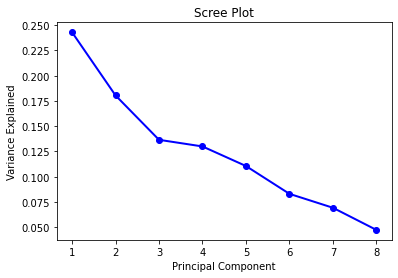

In [20]:
pca = PCA()
pca.fit_transform(scaled_features)
pca_explain = pca.explained_variance_ratio_
print('Explained Variance According to each Feature: ')
print(pca_explain)
#Scree_Plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

As there is no sudden drop in the graph means that we need to analyze more

Cummlative Explained Variance

In [21]:
cum_exp_variance = np.cumsum(pca_explain)
cum_exp_variance

array([0.24297674, 0.4234199 , 0.55992299, 0.68986388, 0.80042636,
       0.88344881, 0.95268664, 1.        ])

Cummlative Explained Variance Visualization

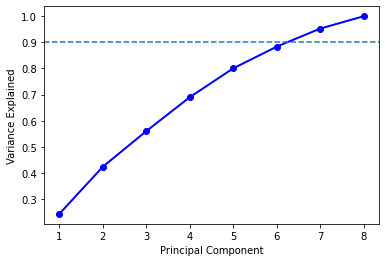

In [22]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, cum_exp_variance, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.axhline(y=0.9, linestyle='--')
plt.show()

As We can see 90% of Variance is covered under first 6 components. So, we will only use first six components for our model

In [23]:
pca = PCA(6, random_state=10)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)
#pd.DataFrame(pca_projection)


# Decision Tree Classifier

In [24]:

train_x,test_x,train_y,test_y = train_test_split(pca_projection,Tracks['genre_top'],test_size=0.2,random_state=40 )
model = DecisionTreeClassifier()
model.fit(train_x,train_y)
prediction = model.predict(test_x)
classificationReport = classification_report(test_y,prediction)
print(classificationReport)

              precision    recall  f1-score   support

     Hip-Hop       0.63      0.66      0.64       195
        Rock       0.91      0.90      0.91       766

    accuracy                           0.85       961
   macro avg       0.77      0.78      0.78       961
weighted avg       0.86      0.85      0.85       961



# Logistic Regression

In [25]:
LogisticModel = LogisticRegression()
LogisticModel.fit(train_x,train_y)
LogisticPrediction = LogisticModel.predict(test_x)
LogicticClassificationReport = classification_report(test_y,LogisticPrediction)
print(LogicticClassificationReport)


              precision    recall  f1-score   support

     Hip-Hop       0.76      0.56      0.64       195
        Rock       0.89      0.95      0.92       766

    accuracy                           0.87       961
   macro avg       0.83      0.76      0.78       961
weighted avg       0.87      0.87      0.87       961



As we can see that both of the models are performing pretty well but the onlything that is not right is that our model is more biared towards Rock Genre which is not ideal.

The reason behind this may be that we have far more Data Points for Rock Songs.

In [26]:
print('Rock Enteries: ')
print(len(Tracks[Tracks['genre_top'] == 'Rock']))
print('Hip-Hop Enteries: ')
print((len(Tracks[Tracks['genre_top'] == 'Hip-Hop'])))

Rock Enteries: 
3892
Hip-Hop Enteries: 
910


# Balancing our Data Set

In [27]:
df_HipHop = Tracks.loc[Tracks["genre_top"] == "Hip-Hop"]
df_Rock = Tracks.loc[Tracks["genre_top"] == "Rock"].sample(len(df_HipHop), random_state=40)
Balanced_df = pd.concat([df_Rock ,df_HipHop])

Repeating Process for Balanced Data

In [28]:
features =Balanced_df.drop(['track_id','genre_top'],axis =1).copy()
scaler = StandardScaler()
scaled_features= scaler.fit_transform(features)

pca = PCA(6, random_state=10)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)

train_x,test_x,train_y,test_y = train_test_split(pca_projection,Balanced_df['genre_top'],test_size=0.2,random_state=40 )

In [29]:
#Decision Tree on Balanced Data
model = DecisionTreeClassifier()
model.fit(train_x,train_y)
prediction = model.predict(test_x)
classificationReport = classification_report(test_y,prediction)

#Logisctic Regression on Balanaced Data

LogisticModel = LogisticRegression()
LogisticModel.fit(train_x,train_y)
LogisticPrediction = LogisticModel.predict(test_x)
LogicticClassificationReport = classification_report(test_y,LogisticPrediction)

# Does balancing our dataset improve model bias?

In [30]:
print('Decision Tree on Balanced Data:')
print(classificationReport)
print('Logistic Regression on Balanced Data:')
print(LogicticClassificationReport)

Decision Tree on Balanced Data:
              precision    recall  f1-score   support

     Hip-Hop       0.82      0.72      0.77       191
        Rock       0.73      0.82      0.77       173

    accuracy                           0.77       364
   macro avg       0.77      0.77      0.77       364
weighted avg       0.77      0.77      0.77       364

Logistic Regression on Balanced Data:
              precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       191
        Rock       0.79      0.84      0.81       173

    accuracy                           0.82       364
   macro avg       0.82      0.82      0.82       364
weighted avg       0.82      0.82      0.82       364



Yes! Balancing did remove the bias from for model. But, we can see that there is decrease in our avg accuracy that is because we have removed datapoint from our dataset. We are okay with this because Biasness is way more dangerous than less accuracy

# KFOLD Cross Validation

In [33]:
kf = KFold(n_splits=10)
tree_score = cross_val_score(model, pca_projection, Balanced_df['genre_top'], cv=kf)
logit_score = cross_val_score(LogisticModel, pca_projection,Balanced_df['genre_top'], cv=kf)
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7478021978021978 Logistic Regression: 0.7818681318681319


So these are our final accuracy for any unseen data